In [2]:
import os
import sys
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import polars as pl
import numpy as np
import optuna  
from scipy.optimize import minimize
import scipy.stats as st

/Users/danielherman/Documents/projects/flickering-neon-lamp/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 184.20it/s]


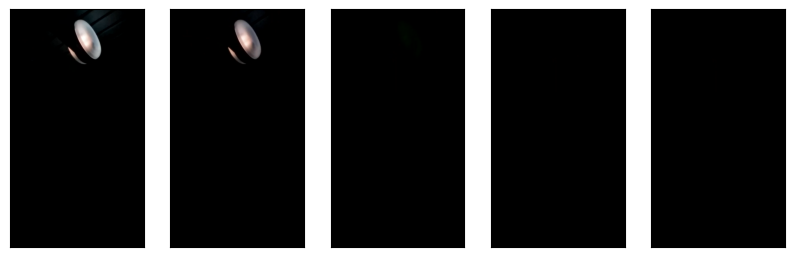

In [3]:
path = './data/frames'
files = os.listdir(path)
files.sort()
imgs = []
for i in tqdm(range(5)):
    img = cv2.imread(os.path.join(path, files[i]))
    imgs.append(img)

fig, ax = plt.subplots(1, 5, figsize=(10, 5))  
for i in range(5):
    ax[i].imshow(imgs[i])   
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

plt.show()  

In [3]:
def process_image(img):
    img = img.astype('float32')
    img /= 255
    img = img.mean(axis=(0, 1, 2))
    return img

measured_states = []
for file in tqdm(files):
    img = cv2.imread(os.path.join(path, file))
    mean = process_image(img)
    img_ind = int(file.split('.')[0].split('-')[1])
    if mean > 0.002:
        new_state = 1
    else:
        new_state = 0
    measured_states.append(new_state)

100%|██████████| 6796/6796 [00:53<00:00, 127.51it/s]


100%|██████████| 6796/6796 [00:00<00:00, 5950832.98it/s]


Text(0, 0.5, 'probability')

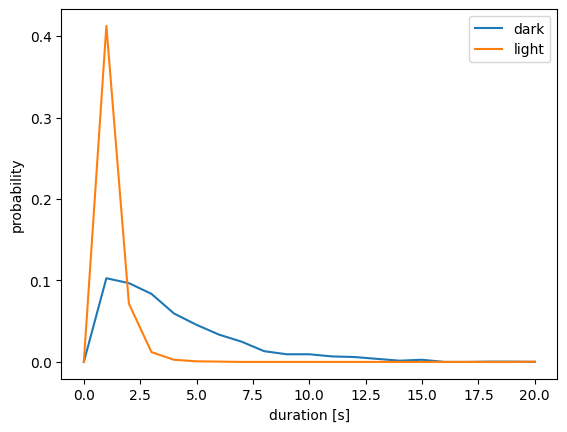

In [4]:
def process_states(measured_states):
    states_stat = []
    state = 0
    duration = 0
    for new_state in tqdm(measured_states):
        if new_state != state:
            states_stat.append((state, duration))
            duration = 0
            state = new_state

        duration += 1

    states_stat = states_stat[1:]
    max_duration = max([x[1] for x in states_stat])
    stats_counts = np.zeros((2, max_duration+1))
    for state, duration in states_stat:
        stats_counts[state, duration] += 1
    
    return stats_counts

states_stats_ref = process_states(measured_states)
states_stats_ref = states_stats_ref / states_stats_ref.sum(axis=(0, 1))
plt.plot(states_stats_ref[0], label='dark')
plt.plot(states_stats_ref[1], label='light')
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('probability')

In [5]:
def simulate_neon_lamp(params, steps=100000):
    k_dh, k_dl, k_hd, k_hl, k_ld, k_lh = params
    step_matrix = np.array([
        [1 - k_dh - k_dl, k_hd, k_ld],
        [k_dh, 1 - k_hd - k_hl, k_lh],
        [k_dl, k_hl, 1 - k_ld - k_lh]
    ])
    state = 0
    observed_light = []
    for i in range(steps):
        state = np.random.choice([0, 1, 2], p=step_matrix[:, state])
        if state == 2:
            observed_light.append(1)
        else:
            observed_light.append(0)

    states_stats = process_states(observed_light)
    states_stats = states_stats[:, :states_stats_ref.shape[1]]
    states_stats = states_stats / states_stats.sum(axis=(0, 1))
    return states_stats

def cost_function(params, steps=10000):
    try:
        states_stats = simulate_neon_lamp(params, steps=steps)
    except:
        return 100
    D, p = st.ks_2samp(states_stats.flatten(), states_stats_ref.flatten())
    return D

In [6]:
def objective(trial):  
    k_dh = trial.suggest_uniform('k_dh', 0, 1)  
    k_dl = trial.suggest_uniform('k_dl', 0, 1-k_dh)  
    k_hd = trial.suggest_uniform('k_hd', 0, 1)  
    k_hl = trial.suggest_uniform('k_hl', 0, 1-k_hd)  
    k_ld = trial.suggest_uniform('k_ld', 0, 1)  
    k_lh = trial.suggest_uniform('k_lh', 0, 1-k_ld)  
    params = [k_dh, k_dl, k_hd, k_hl, k_ld, k_lh]  
    return cost_function(params, steps=10000)  
  
sampler = optuna.samplers.TPESampler(n_startup_trials=1000)  
study = optuna.create_study(sampler=sampler, direction='minimize')  
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=5000)
  
print(study.best_params)  

[I 2023-10-18 00:07:40,955] A new study created in memory with name: no-name-c086c222-914b-4dfa-b86b-09a7b1a51ab4
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dh = trial.suggest_uniform('k_dh', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dl = trial.suggest_uniform('k_dl', 0, 1-k_dh)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

{'k_dh': 0.9542279125847726, 'k_dl': 0.028611112533898475, 'k_hd': 0.0704892878561878, 'k_hl': 0.25727044874319377, 'k_ld': 0.006931530777023354, 'k_lh': 0.8850890203772394}


In [7]:
def objective_focused(trial, params, delta=0.15):  
    k_dh_prev, k_dl_prev, k_hd_prev, k_hl_prev, k_ld_prev, k_lh_prev = params
    k_dh = trial.suggest_uniform('k_dh', max(0, k_dh_prev - delta), min(1, k_dh_prev + delta))
    k_dl = trial.suggest_uniform('k_dl', max(0, k_dl_prev - delta), min(1 - k_dh, k_dl_prev + delta))
    k_hd = trial.suggest_uniform('k_hd', max(0, k_hd_prev - delta), min(1, k_hd_prev + delta))
    k_hl = trial.suggest_uniform('k_hl', max(0, k_hl_prev - delta), min(1 - k_hd, k_hl_prev + delta))  
    k_ld = trial.suggest_uniform('k_ld', max(0, k_ld_prev - delta), min(1, k_ld_prev + delta))
    k_lh = trial.suggest_uniform('k_lh', max(0, k_lh_prev - delta), min(1 - k_ld, k_lh_prev + delta))
    params = [k_dh, k_dl, k_hd, k_hl, k_ld, k_lh]  
    return cost_function(params, steps=10000)  

params = study.best_params.values()
print(params)
sampler = optuna.samplers.TPESampler(n_startup_trials=1000)  
study = optuna.create_study(sampler=sampler, direction='minimize')  
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=5000)

/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dh = trial.suggest_uniform('k_dh', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dl = trial.suggest_uniform('k_dl', 0, 1-k_dh)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_hd = trial.suggest_uniform('k_hd', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykern

dict_values([0.9542279125847726, 0.028611112533898475, 0.0704892878561878, 0.25727044874319377, 0.006931530777023354, 0.8850890203772394])


100%|██████████| 10000/10000 [00:00<00:00, 5502891.63it/s]


In [8]:
def objective_focused(trial, params, delta=0.10):  
    k_dh_prev, k_dl_prev, k_hd_prev, k_hl_prev, k_ld_prev, k_lh_prev = params
    k_dh = trial.suggest_uniform('k_dh', max(0, k_dh_prev - delta), min(1, k_dh_prev + delta))
    k_dl = trial.suggest_uniform('k_dl', max(0, k_dl_prev - delta), min(1 - k_dh, k_dl_prev + delta))
    k_hd = trial.suggest_uniform('k_hd', max(0, k_hd_prev - delta), min(1, k_hd_prev + delta))
    k_hl = trial.suggest_uniform('k_hl', max(0, k_hl_prev - delta), min(1 - k_hd, k_hl_prev + delta))  
    k_ld = trial.suggest_uniform('k_ld', max(0, k_ld_prev - delta), min(1, k_ld_prev + delta))
    k_lh = trial.suggest_uniform('k_lh', max(0, k_lh_prev - delta), min(1 - k_ld, k_lh_prev + delta))
    params = [k_dh, k_dl, k_hd, k_hl, k_ld, k_lh]  
    return cost_function(params, steps=100000)  

params = study.best_params.values()
print(params)
sampler = optuna.samplers.TPESampler(n_startup_trials=500)  
study = optuna.create_study(sampler=sampler, direction='minimize')  
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=2000)

/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dh = trial.suggest_uniform('k_dh', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dl = trial.suggest_uniform('k_dl', 0, 1-k_dh)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1716777003.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_hd = trial.suggest_uniform('k_hd', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykern

dict_values([0.8562681489594773, 0.0604280479061357, 0.5311412590179759, 0.36572704560425756, 0.2502759397757538, 0.7289665441580216])


100%|██████████| 10000/10000 [00:00<00:00, 5575307.72it/s]


In [9]:
# k_dh, k_dl, k_hd, k_hl, k_ld, k_lh = (0.11844279613330722,
#  0.2626489532578869,
#  0.5470536838977099,
#  0.4121388898727857,
#  0.812554612175568,
#  0.0373958686824491)

In [18]:
k_dh, k_dl, k_hd, k_hl, k_ld, k_lh = (0.935522587611131,
 0.060659537142609916,
 0.5704492078246726,
 0.40470009944539087,
 0.3169837876638313,
 0.6098098196619585)

100%|██████████| 100000/100000 [00:00<00:00, 5704440.55it/s]


Text(0, 0.5, 'probability')

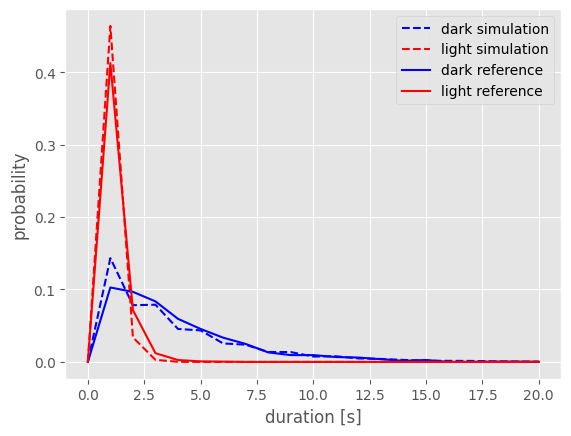

In [19]:
params = k_dh, k_dl, k_hd, k_hl, k_ld, k_lh
states_stats = simulate_neon_lamp(params, steps=100000)
vmax = max(states_stats.max(), states_stats_ref.max())

plt.plot(states_stats[0], label='dark simulation', c="b", linestyle="dashed")
plt.plot(states_stats[1], label='light simulation', c="r", linestyle="dashed")
plt.plot(states_stats_ref[0], label='dark reference', c="b", linestyle="solid")
plt.plot(states_stats_ref[1], label='light reference', c="r", linestyle="solid")
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('probability')

Text(0, 0.5, 'p_sim - p_ref')

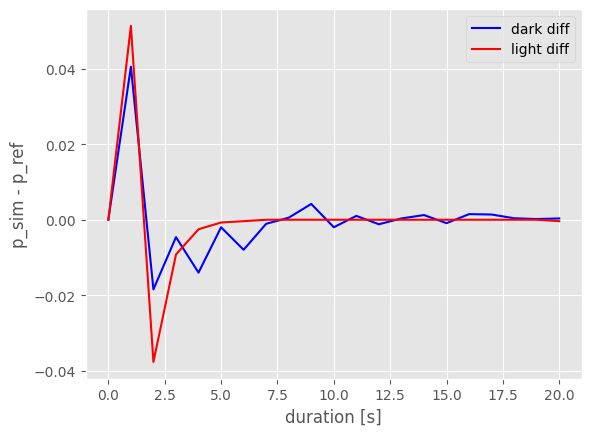

In [20]:
plt.plot(states_stats[0] - states_stats_ref[0], label='dark diff', c="b", linestyle="solid")
plt.plot(states_stats[1] - states_stats_ref[1], label='light diff', c="r", linestyle="solid")
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('p_sim - p_ref')

/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_6716/1990860430.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study) #, params=['k_dh', 'k_dl'])
[W 2023-10-18 09:01:48,863] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


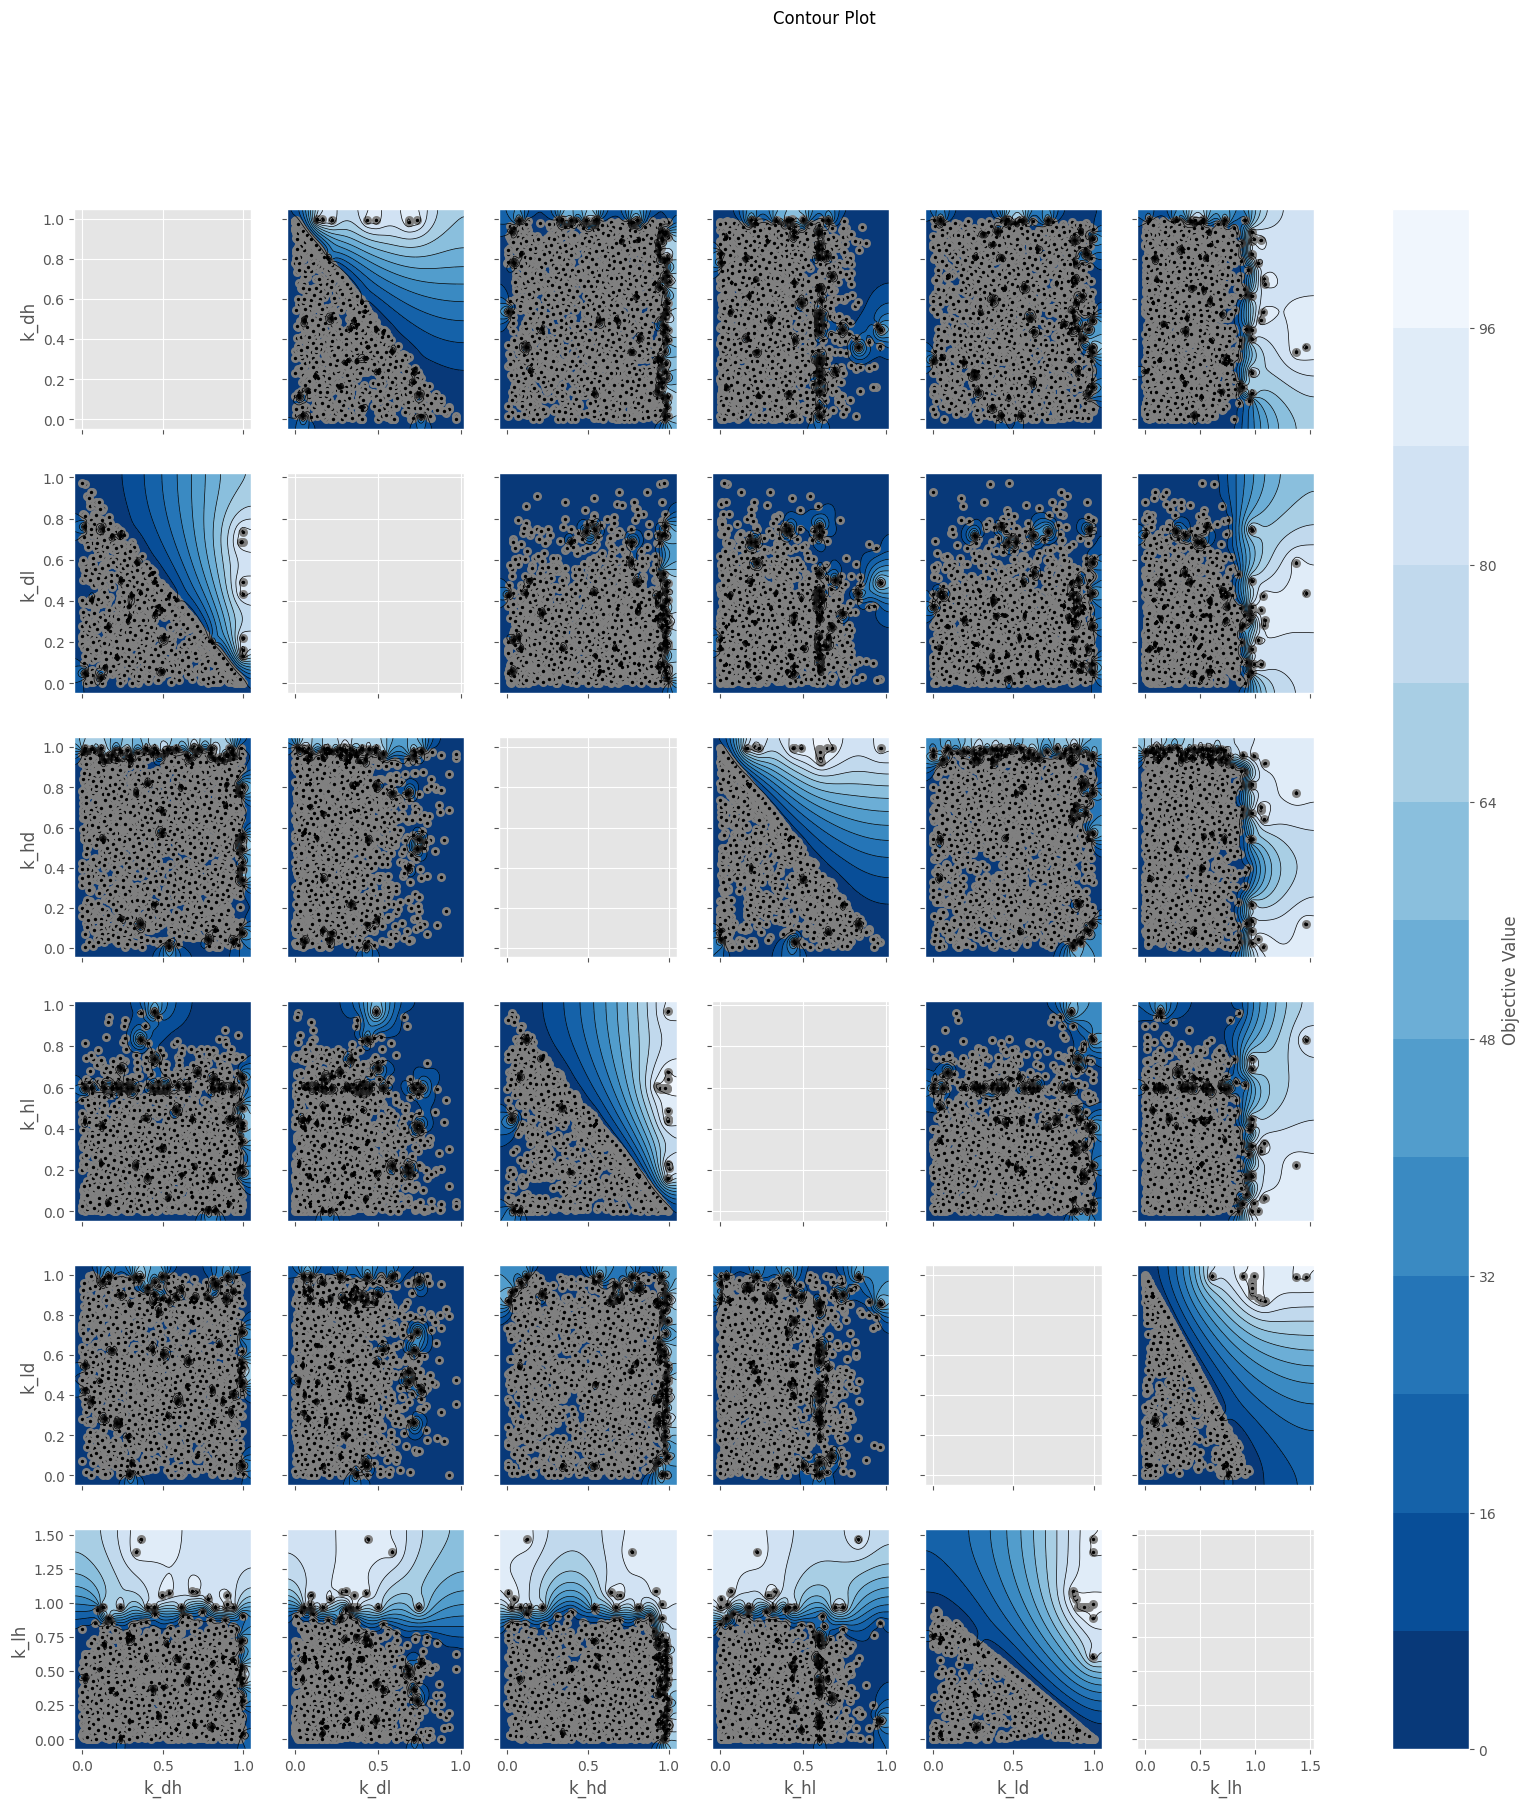

In [21]:
optuna.visualization.matplotlib.plot_contour(study) #, params=['k_dh', 'k_dl'])
fig = plt.gcf()
fig.set_size_inches(20, 20)

In [22]:
step_matrix = np.array([
    [1 - k_dh - k_dl, k_hd,            k_ld           ],
    [k_dh,            1 - k_hd - k_hl, k_lh           ],
    [k_dl,            k_hl,            1 - k_ld - k_lh]
])

step_matrix.round(3)

array([[0.004, 0.57 , 0.317],
       [0.936, 0.025, 0.61 ],
       [0.061, 0.405, 0.073]])